# Flow Neighbor Loss on Toy Datasets



In [ ]:
# default_exp flow_neighbor_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

In [ ]:
from directed_graphs.diffusion_distance_flow_embedder import FixedDiffusionMapEmbedding
from directed_graphs.multiscale_flow_embedder import MultiscaleDiffusionFlowEmbedder
from directed_graphs.flow_embedding_training_utils import (
    FETrainer,
    visualize_points,
    save_embedding_visualization,
)
from directed_graphs.diffusion_flow_embedding import (
    affinity_matrix_from_pointset_to_pointset,
)
import torch.nn.functional as F
import torch

class FlowNeighborEmbedder(FETrainer):
    def __init__(
        self,
        X,
        flows,
        labels,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        sigma_graph=2.13,
        flow_strength_graph=1,
    ):
        super().__init__(X, flows, labels, device=device)
        self.vizfiz = [
            save_embedding_visualization,
            visualize_points,
        ]
        loss_weights = {
            "diffusion": 0,
            "smoothness": 0,
            "reconstruction": 0,
            "diffusion map regularization": 1,
            "flow cosine loss": 0,
            "flow neighbor loss": 1e-4,
        }
        self.FE = MultiscaleDiffusionFlowEmbedder(
            X=X,
            flows=flows,
            ts=[1],
            sigma_graph=sigma_graph,
            flow_strength_graph=flow_strength_graph,
            device=device,
            use_embedding_grid=False,
            embedder=FixedDiffusionMapEmbedding(X, t=1, k=18, device=device),
            loss_weights = loss_weights,
        ).to(device)
        self.title = "Naked Flow Neighbor Embeddings"
        self.epochs_between_visualization = 100
        self.total_epochs = 1000

# A Battery of Embedding Tests

In [ ]:
from directed_graphs.datasets import (
    directed_circle,
    directed_cylinder,
    directed_spiral,
    directed_swiss_roll_sklearn,
    plot_directed_2d,
    affinity_grid_search
)

## The Circle

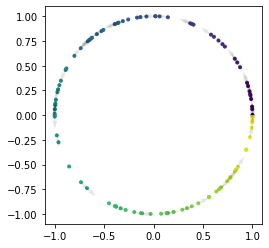

In [ ]:
X, flow, labels = directed_circle()
plot_directed_2d(X,flow,labels)

Find a good sigma and flow strength

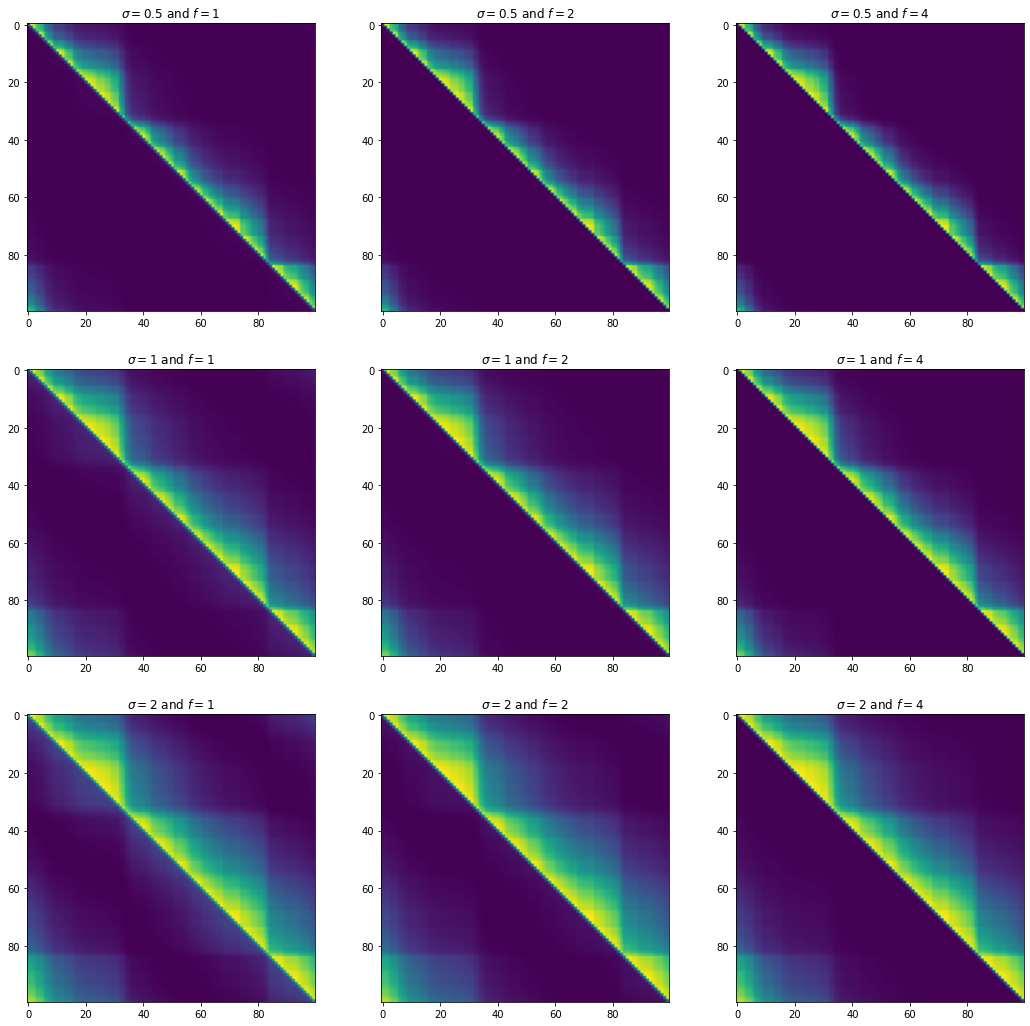

In [ ]:
affinity_grid_search(X,flow,sigmas=[0.5, 1, 2],flow_strengths = [1,2,4])

In [ ]:
X = torch.tensor(X).to(device).float()
flow = torch.tensor(flow).to(device).float()
fe = FlowNeighborEmbedder(X, flow, labels,sigma_graph = 1, flow_strength_graph=1)

Using loss weights: {'diffusion': 1, 'smoothness': 0, 'reconstruction': 0, 'diffusion map regularization': 0, 'flow cosine loss': 0, 'flow neighbor loss': 0}
using sigma =  0.537797
Using loss weights: {'diffusion': 0, 'smoothness': 0, 'reconstruction': 0, 'diffusion map regularization': 1, 'flow cosine loss': 0, 'flow neighbor loss': 0.0001}


ValueError: unrecognized csr_matrix constructor usage

In [ ]:
fe.fit()